## Warmstart + Mitiq + Error Mitigation + Optuna (IBM)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import qiskit
provider = qiskit.IBMQ.load_account()

In [3]:
import optuna
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, SlsqpOptimizer,  CobylaOptimizer
from qiskit.ignis.mitigation import CompleteMeasFitter

from shared.QiskitMaxcut import *
from shared.Mitiq_QAOA import *
from ibm.ibm_parameters import *

%matplotlib inline

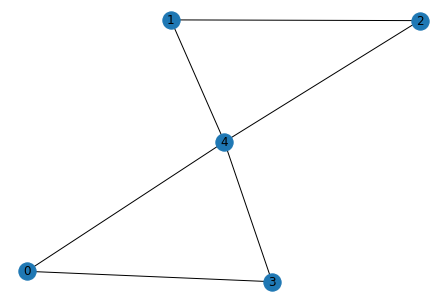

In [4]:
print_parameters()

In [ ]:
# ---- Define graph and MaxCut ----
graph = load_graph()
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [5]:
def init_qaoa(optimizer, reps, init_parameters):
    quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS,
                    measurement_error_mitigation_cls=CompleteMeasFitter,
                    measurement_error_mitigation_shots=SHOTS
    )

    # generate QAOA to get circuit
    pre_qaoa = QAOA(optimizer=COBYLA(maxiter=1, tol=0), quantum_instance=quantum_instance, reps=reps, initial_point=init_parameters)
    MinimumEigenOptimizer(pre_qaoa).solve(max_cut_qubo)

    circuit = pre_qaoa.get_optimal_circuit()
    circuit.measure_all()

    if optimizer == "QN-SPSA":
        fidelity = QNSPSA.get_fidelity(pre_qaoa.ansatz)
        optimizer = QNSPSA(fidelity, maxiter=MAX_ITER)

    mitiq_qaoa = Mitiq_QAOA(mitiq_circuit=circuit.copy(),
                            optimizer=optimizer,
                            quantum_instance=quantum_instance,
                            reps=reps,
                            initial_point=init_parameters)

    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=SlsqpOptimizer(), relax_for_pre_solver=True,
                                 qaoa=mitiq_qaoa)

    return ws_qaoa

In [6]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    result = qaoa.solve(max_cut_problem)
    optimal_parameters = qaoa._qaoa.optimal_params
    return result, optimal_parameters.copy()

In [7]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]

    qaoa = init_qaoa(optimizer, reps, parameters)

    result, optimal_parameters = run(max_cut_qubo, qaoa)

    mean, distribution = max_cut.analyse(result)

    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters, optimizer_name])

    return mean

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-07-27 14:35:53,804] A new study created in memory with name: no-name-be81786d-bcc1-465a-873c-92b99cf020e4
/var/folders/fn/1fd59zzx3yv9s4hv8s5hrlw00000gn/T/ipykernel_27477/612271657.py:5: DeprecationWarning: 
The VQE.optimal_params property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.optimal_point.
  optimal_parameters = qaoa.optimal_params
[I 2021-07-27 14:37:01,328] Trial 0 finished with value: 18.8376249782888 and parameters: {'optimizer': 'SPSA', 'reps': 9, 'gamma_0': 3.0483079689539023, 'gamma_1': 1.889365253264244, 'gamma_2': 1.0924360445007109, 'gamma_3': 1.153361724282158, 'gamma_4': -1.431826271437429, 'gamma_5': 1.2269459809789325, 'gamma_6': -0.5231625190803482, 'gamma_7': 1.8414415065031742, 'gamma_8': -3.0482635632755426, 'beta_0': 2.4914105861154905, 'beta_1': -1.6422255258829963, 'beta_2': 1.104535362097586, 'beta_3'

optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
-18.8376249782888


[I 2021-07-27 14:38:02,754] Trial 1 finished with value: 23.990250017221808 and parameters: {'optimizer': 'SPSA', 'reps': 7, 'gamma_0': 0.8878407520041591, 'gamma_1': -1.7929217185423352, 'gamma_2': -1.446020504985837, 'gamma_3': -1.5754207001720268, 'gamma_4': -2.3626095996492342, 'gamma_5': -1.1358512554107372, 'gamma_6': -0.9975022284315527, 'beta_0': 3.0252909644333474, 'beta_1': -2.6207692662393773, 'beta_2': -2.954757383028052, 'beta_3': 1.2574768829551672, 'beta_4': -0.14414582743122129, 'beta_5': 0.747153891973015, 'beta_6': -1.7418400346648701}. Best is trial 0 with value: 18.8376249782888.


optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
-23.990250017221808


In [9]:
print(study.best_trial)

FrozenTrial(number=0, values=[18.8376249782888], datetime_start=datetime.datetime(2021, 7, 27, 14, 35, 53, 807726), datetime_complete=datetime.datetime(2021, 7, 27, 14, 37, 1, 321233), params={'optimizer': 'SPSA', 'reps': 9, 'gamma_0': 3.0483079689539023, 'gamma_1': 1.889365253264244, 'gamma_2': 1.0924360445007109, 'gamma_3': 1.153361724282158, 'gamma_4': -1.431826271437429, 'gamma_5': 1.2269459809789325, 'gamma_6': -0.5231625190803482, 'gamma_7': 1.8414415065031742, 'gamma_8': -3.0482635632755426, 'beta_0': 2.4914105861154905, 'beta_1': -1.6422255258829963, 'beta_2': 1.104535362097586, 'beta_3': -2.019619683071868, 'beta_4': -1.514065666637965, 'beta_5': -2.1579157472998354, 'beta_6': -1.7291104096032266, 'beta_7': -1.8644338452778182, 'beta_8': -1.1409806603842352}, distributions={'optimizer': CategoricalDistribution(choices=('SPSA', 'COBYLA')), 'reps': IntUniformDistribution(high=10, low=1, step=1), 'gamma_0': UniformDistribution(high=3.141592653589793, low=-3.141592653589793), 'gam

In [26]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params, optimizer_name = study.user_attrs["best"]
print(f"Optimizer: {optimizer_name}")
print(f"Optimal Parameters: {optimal_params}")

In [27]:
max_cut.draw(result)

array([ 2.54688176, -0.93615441, -0.7789562 ,  3.4777998 ,  0.31144345,
       -0.09676931,  0.0675467 ,  0.30564694,  1.05463352, -1.98108075,
        0.220484  ,  1.69062969])

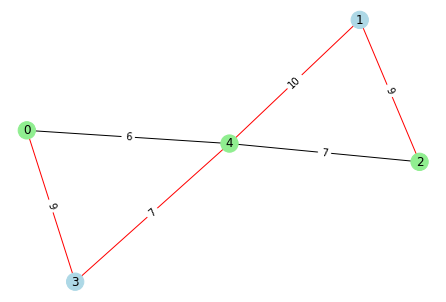

In [28]:
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

optimal function value: 35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Mean: 28.8784144081116
01010: value: 35.000, probability: 6.8%
10101: value: 35.000, probability: 6.6%
00111: value: 34.000, probability: 2.7%
11000: value: 34.000, probability: 2.8%
01110: value: 33.000, probability: 2.0%
10001: value: 33.000, probability: 2.3%
00011: value: 32.000, probability: 11.4%
00101: value: 32.000, probability: 8.3%
00110: value: 32.000, probability: 1.7%
11001: value: 32.000, probability: 1.6%
11010: value: 32.000, probability: 8.4%
11100: value: 32.000, probability: 11.4%
01011: value: 31.000, probability: 5.0%
10100: value: 31.000, probability: 5.2%
00001: value: 30.000, probability: 1.0%
11110: value: 30.000, probability: 1.2%
01001: value: 29.000, probability: 1.1%
10110: value: 29.000, probability: 1.0%
01000: value: 19.000, probability: 1.0%
10111: value: 19.000, probability: 1.1%
01100: value: 17.000, probability: 2.4%
10011: value: 17.000, probability: 2.6%
00010: value: 16.0

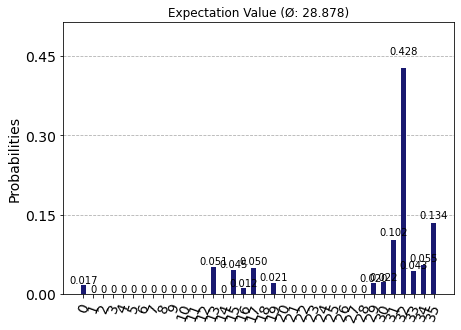

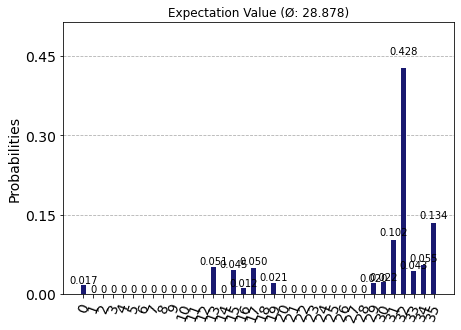

In [29]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
import mitiq
mitiq.about()
